In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs6353/assignments/assignment2/'
FOLDERNAME = 'CS6353/Assignments/assignment2/assignment2/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs6353/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

# Install requirements from colab_requirements.txt
# TODO: Please change your path below to the colab_requirements.txt file
! python -m pip install -r /content/drive/My\ Drive/$FOLDERNAME/colab_requirements.txt

Mounted at /content/drive
/content/drive/My Drive/CS6353/Assignments/assignment2/assignment2/cs6353/datasets
--2024-09-29 20:36:13--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  16.0MB/s    in 11s     

2024-09-29 20:36:25 (14.3 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
/content/drive/My Drive/CS6353/Assignments/assignment2/assignment2
     ━━━━━━━

# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://utah.instructure.com/courses/919972/assignments/12590082) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [ ]:
# Run some setup code for this notebook.
from __future__ import print_function
import random
import numpy as np
from cs6353.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [ ]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs6353/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


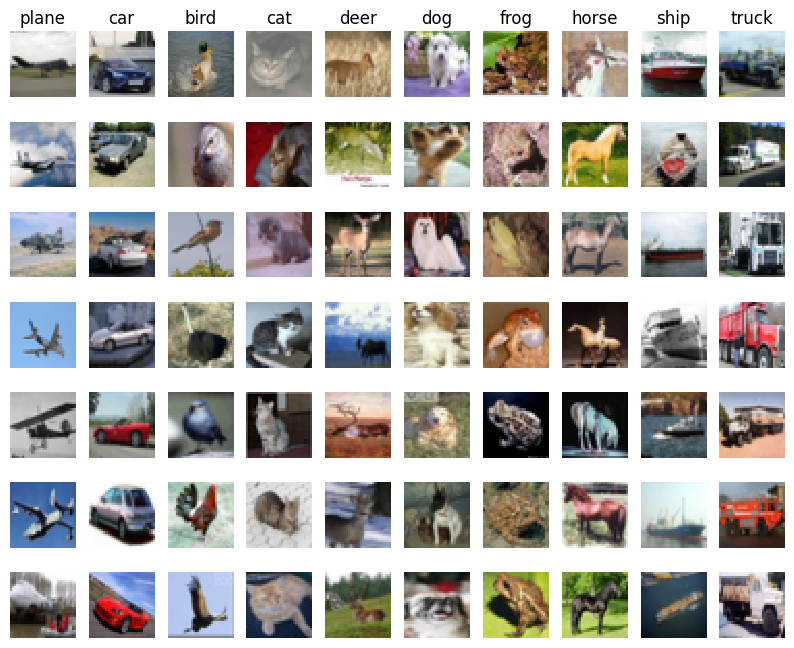

In [ ]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [ ]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [ ]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


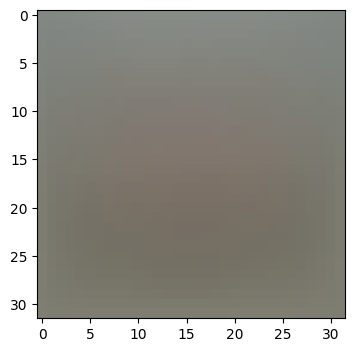

In [ ]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [ ]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [ ]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs6353/classifiers/linear_svm.py**.

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function.

In [ ]:
# Evaluate the naive implementation of the loss we provided for you:
from cs6353.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)

print('grad: ', grad)
print('loss: %f' % (loss, ))

grad:  [[-7.58906714e+00 -1.88964172e+01  2.29122651e-01 ... -1.30679194e+01
  -2.68278514e+01 -3.43442310e+01]
 [-1.58692786e+01 -1.64492239e+01  5.92289490e+00 ... -1.48404657e+01
  -3.08738904e+01 -3.80082373e+01]
 [-4.13668257e+01 -2.11124593e+01  1.66665661e+01 ... -1.23278091e+01
  -4.89268435e+01 -4.44916272e+01]
 ...
 [-2.09256629e+01 -1.61254797e+01  9.72253306e+00 ... -2.10444046e+01
   2.92848282e+01 -1.55055636e+01]
 [-3.73340300e+01 -1.88117226e+01  1.26799271e+01 ... -1.07235640e+01
   8.10160257e+00 -1.85803117e+01]
 [-6.99999995e-02 -2.86000001e-01 -1.70000000e-01 ...  8.40000005e-02
   5.99999688e-03  2.05999999e-01]]
loss: 8.830742


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [ ]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs6353.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -1.836874 analytic: -1.836874, relative error: 4.933138e-11
numerical: 7.346344 analytic: 7.346344, relative error: 1.374043e-11
numerical: -1.583480 analytic: -1.572928, relative error: 3.343141e-03
numerical: 2.739409 analytic: 2.739409, relative error: 2.377995e-11
numerical: 9.991404 analytic: 9.991404, relative error: 5.010525e-12
numerical: -33.077543 analytic: -33.077543, relative error: 5.846195e-12
numerical: 8.632547 analytic: 8.669070, relative error: 2.110998e-03
numerical: 0.766813 analytic: 0.766813, relative error: 1.443983e-10
numerical: -38.545572 analytic: -38.627434, relative error: 1.060759e-03
numerical: -8.611617 analytic: -8.611617, relative error: 1.130704e-11
numerical: 9.394738 analytic: 9.394738, relative error: 7.961307e-12
numerical: -3.066593 analytic: -3.066593, relative error: 1.101293e-10
numerical: -13.585245 analytic: -13.585245, relative error: 5.498565e-12
numerical: 1.604586 analytic: 1.604586, relative error: 9.601810e-11
numerical: 6.8

### Inline Question 1:
It is possible that once in a while a dimension in the gradient check will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** The mismatch in the dimension of the gradient check can occur due to the SVM loss function not being continously differentiable. The SVM loss function is defined as max(0, x), where x is the difference between the scores of incorrect and correct classes plus delta. If x < 0 the loss gets clipped to 0. Hence, at the Hinge x = 0, the loss function is undefined and hence we cannot differentiate. This can cause the discrepancy.

We can skip the gradient update step when this error occurs. Since the occurrence of such an error is rare, it is not an cause of concern.

A simple example where the gradient check will fail is:
Modulus function |x|, at x = 0 the gradient check for this function will fail.

Consider the function max(0, x). If we increase the magin delta, the possibility of x being negative reduces, hence the possibility of loss being 0 reduces and hence the frequency of gradient check failing reduces.

In [ ]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs6353.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.830742e+00 computed in 0.099236s
Vectorized loss: 8.830742e+00 computed in 0.011614s
difference: 0.000000


In [ ]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.091855s
Vectorized loss and gradient: computed in 0.009065s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.  Your code for this part will be written inside `cs6353/classifiers/linear_classifier.py`.

In [ ]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs6353.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 796.412384
iteration 100 / 1500: loss 290.687019
iteration 200 / 1500: loss 108.979117
iteration 300 / 1500: loss 42.586333
iteration 400 / 1500: loss 18.861781
iteration 500 / 1500: loss 10.370017
iteration 600 / 1500: loss 6.483616
iteration 700 / 1500: loss 5.515384
iteration 800 / 1500: loss 5.363760
iteration 900 / 1500: loss 5.640452
iteration 1000 / 1500: loss 4.680338
iteration 1100 / 1500: loss 5.723385
iteration 1200 / 1500: loss 5.408608
iteration 1300 / 1500: loss 4.616177
iteration 1400 / 1500: loss 4.930543
That took 9.644955s


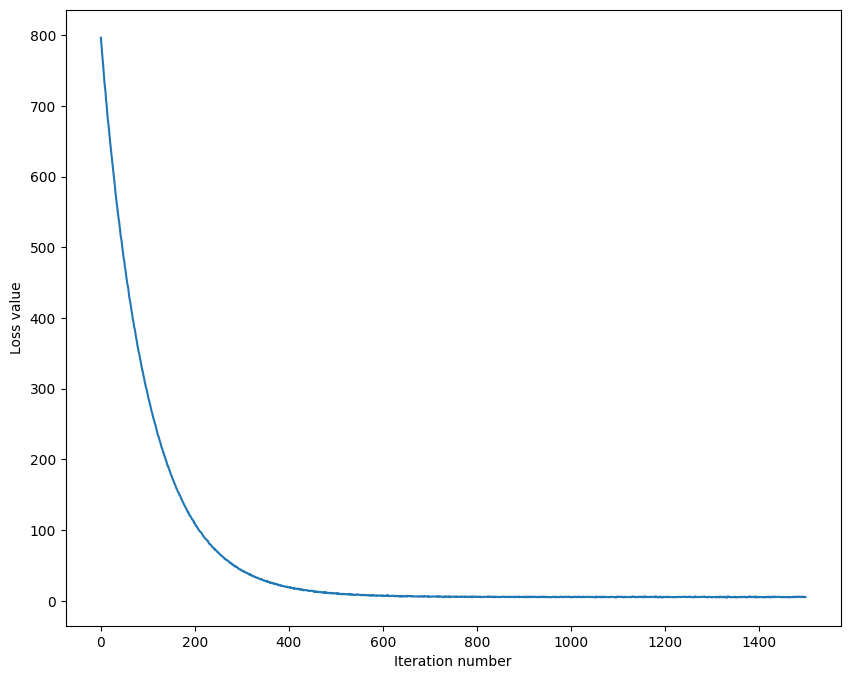

In [ ]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.371286
validation accuracy: 0.376000


In [ ]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 2e-7, 5e-6, 5e-5]
regularization_strengths = [5e3, 2.5e4, 5e4, 1e5]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:

        svm = LinearSVM()

        svm.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1500, verbose=True)

        y_train_pred = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)

        train_results = y_train_pred == y_train
        y_train_accuracy = np.mean(train_results)

        val_results = y_val_pred == y_val
        y_val_accuracy = np.mean(val_results)

        results[(lr, reg)] = (y_train_accuracy, y_val_accuracy)

        if y_val_accuracy > best_val:
            best_val = y_val_accuracy
            best_svm = svm

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 178.244227
iteration 100 / 1500: loss 134.383499
iteration 200 / 1500: loss 108.965742
iteration 300 / 1500: loss 89.827161
iteration 400 / 1500: loss 73.827566
iteration 500 / 1500: loss 60.892688
iteration 600 / 1500: loss 50.312921
iteration 700 / 1500: loss 41.541130
iteration 800 / 1500: loss 35.354586
iteration 900 / 1500: loss 28.906567
iteration 1000 / 1500: loss 24.374831
iteration 1100 / 1500: loss 21.776227
iteration 1200 / 1500: loss 17.810968
iteration 1300 / 1500: loss 15.919390
iteration 1400 / 1500: loss 13.630636
iteration 0 / 1500: loss 791.273070
iteration 100 / 1500: loss 289.199177
iteration 200 / 1500: loss 108.022782
iteration 300 / 1500: loss 42.459306
iteration 400 / 1500: loss 18.652796
iteration 500 / 1500: loss 10.216656
iteration 600 / 1500: loss 7.226874
iteration 700 / 1500: loss 6.247032
iteration 800 / 1500: loss 5.329904
iteration 900 / 1500: loss 6.004492
iteration 1000 / 1500: loss 5.448198
iteration 1100 / 1500: loss 5.38996

/content/drive/MyDrive/CS6353/Assignments/assignment2/assignment2/cs6353/classifiers/linear_svm.py:100: RuntimeWarning: overflow encountered in scalar multiply
  loss += reg * np.sum(W * W)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  
/content/drive/MyDrive/CS6353/Assignments/assignment2/assignment2/cs6353/classifiers/linear_svm.py:100: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)


iteration 900 / 1500: loss inf
iteration 1000 / 1500: loss inf
iteration 1100 / 1500: loss inf
iteration 1200 / 1500: loss inf
iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss inf
iteration 0 / 1500: loss 1558.822219
iteration 100 / 1500: loss 4207798039246850533175537350026849985891957311066635763731421068684681551426265889564213148587107320794663181729815999807488.000000
iteration 200 / 1500: loss 10865585973859512794324652083082151377428692078654146335946470231097929239192116128043930123319357484907821011382111736380297078929685288281354444057281064855477818255968338724444959005748132168902582123452399105113895867022682238881250555199488.000000
iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf


/content/drive/MyDrive/CS6353/Assignments/assignment2/assignment2/cs6353/classifiers/linear_svm.py:125: RuntimeWarning: overflow encountered in multiply
  dW += 2 * reg * W
/content/drive/MyDrive/CS6353/Assignments/assignment2/assignment2/cs6353/classifiers/linear_classifier.py:70: RuntimeWarning: invalid value encountered in subtract
  self.W -= learning_rate * grad


iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 3071.075695
iteration 100 / 1500: loss 218213330994636659925348406968188519078545208030282046147972028616823464917607627624562344551622600051249465700080001779529813525570097695761342850588122872372114047619043797859518559655959724032.000000
iteration 200 / 1500: loss inf
iteration 300 / 1500: loss inf


/content/drive/MyDrive/CS6353/Assignments/assignment2/assignment2/cs6353/classifiers/linear_svm.py:94: RuntimeWarning: invalid value encountered in subtract
  margins = np.maximum(0, scores - correct_class_scores + 1)


iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
lr 1.000000e-07 reg 5.000000e+03 train accuracy: 0.372122 val accuracy: 0.367000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.367551 val accuracy: 0.378000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.356694 val accuracy: 0.366000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.335776 val accuracy: 0.357000
lr 2.000000e-07 reg 5.000000e+03 train accuracy: 0.384673 val accuracy: 0.385000
lr 2.000000e-07 reg 2.500000e+04 train accuracy: 0.364837 val accuracy: 0.377000
lr 2.000000e-07 reg 5.000000e+04 train accuracy: 0.344490 val accuracy: 0.350000
lr 2.000000e-07 reg 1.000000e+05 train accuracy: 0.318592 val accuracy: 0.341000
lr 5.0

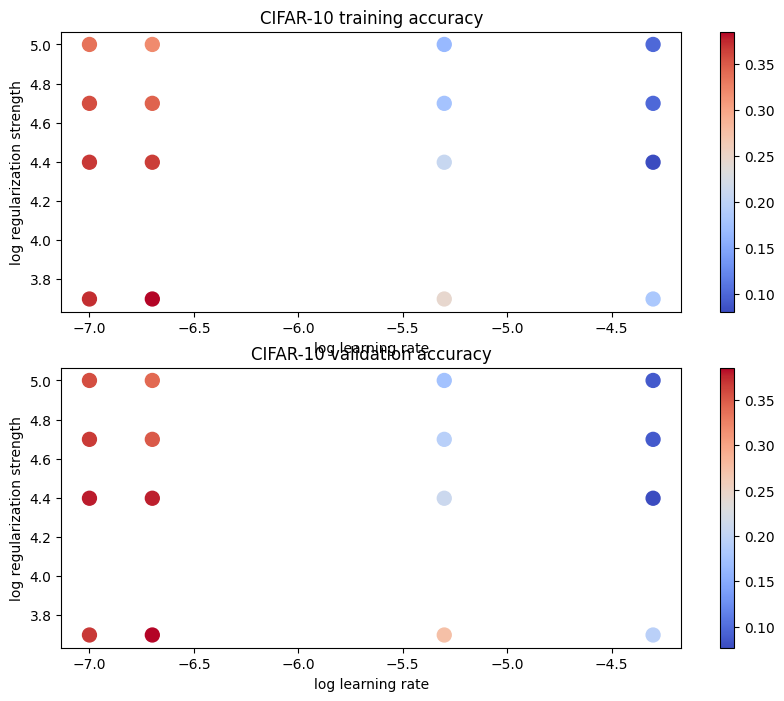

In [ ]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)

# plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)


plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)

# plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)


plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [ ]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.379000


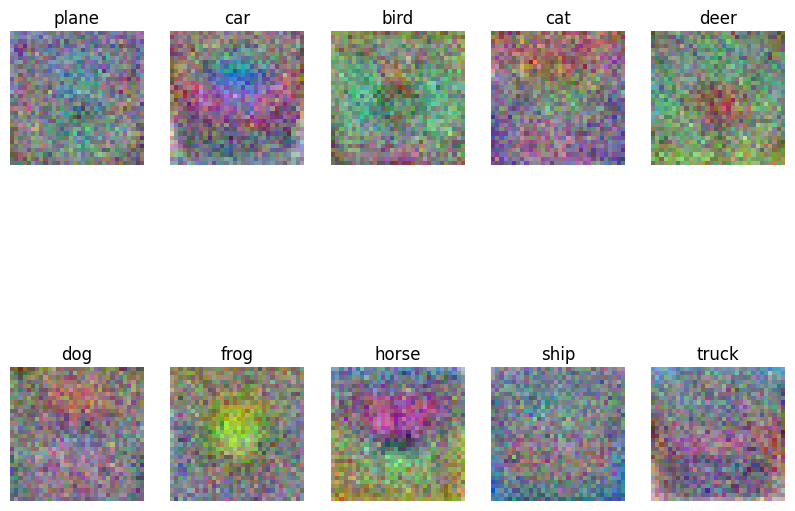

In [ ]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way that they do.

**Your answer:** The visualized SVM weights act as templates for each class, learned from the patterns in the training data. These weights represent the core features that define the images belonging to each class. When classifying a test image, SVM computes the inner product between the test image and each class's template. This inner product measures how closely the test image aligns with the learned features of each class, helping determine which class the image most likely belongs to. For instance, an frog is usually green in colour, hence the image shows a big green circle in the centre.